# Spark SQL
## Lab assignment: Exercises with MapReduce on Spark SQL - Dataframes

The aim of this notebook is to play with the DataFrame API of Apache Spark, aiming to solve the same MapReduce exercises we did for the previous labs.

The key difference will be the programming style, which will be more SQL-like. You should always use the functions provided by SparkSQL, I will import these functions as 'F', so we know for sure we are using Spark functions and not Python functions!

**Note**: I have decided to leave out the exercise about the list of common friends between pairs of friends with DataFrames. Whilst definitely possible, I don't see much point in doing so. You could try and let me know how you get on with it, but you might need to use User-Defined Functions, or other functions I didn't explain.

## Submission and marking criteria

You should complete this notebook and add your solutions to it. When you are done, rename your completed notebook as `ex03.ipynb`. 

Important notes:
- The **group leader** must submit the `ex03.ipynb` file on Moodle.
- **Each member of the group** must complete the peer review survey and their contribution statement using this [link](https://forms.office.com/e/aAFaCQ2uxU). **You can only submit this survey ONCE**.
- This lab is marked out of 100 marks. We give you 10 marks for completing exercise 0 with our help, and the three remaining exercises are worth 30 marks each.
- The marking will be focused on:
    - Code that does solve the task correctly (15 marks).
    - Efficiency of the solution (15 marks).
    - Minor mistakes will deduct marks from each exercise.
- **Submission deadline: 15th March 2024 at 3pm**

## Set-up

The first thing we need to do to start working with Spark is to initialize the `SparkSession`. We will also import a few libraries we will use. *Remember if you are using Databricks that `spark` and `sc` are already available to you and don't need initializing.* 

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import findspark


findspark.init()
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Spark SQL Lab") \
    .getOrCreate() 

sc = spark.sparkContext 

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from pyspark.sql import functions as F  # I import all Spark Functions, like length, when, explode...
from pyspark.sql import Row

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("1 test passed.") if var == val else print("1 test failed. " + msg)

## Exercise 0: Word Count with DataFrames

As a warm-up, let's implement the Word Count with DataFrames. As in the previous lab, you're as asked to implement a `word_count(file_path)` function that counts the number of words in a document or a number of text documents provided in the input path.

**Input:** The path to a text file

**Output:** (word, count) - only the 10 words with the highest frequency!

Recommended steps:
1. Read the file or files. Each line should be an element of the DataFrame.
2. Split the lines into words. (*transformation*)
3. Filter empty words (`''`) resulting from previous steps. (*transformation*)
4. Count the number of occurrences of each word. (*action*)
5. Return to the driver program the 10 most repeated words. (*action*)

**Additional challenge**: Improve the word count, eliminating any punctuation marks and avoid word duplicated due to capitalisation. *Advice*: Use SQL functions like: regexp_replace, trim, col or lower.

We are providing a step-by-step solution for this exercise below (yes! we are this nice!), but we suggest you try it yourself first.

                                                                                                       [10 marks]

In [196]:

def word_count(file_path):
    #<FILL-IN WITH YOUR CODE>
    text=spark.read.text(file_path)
    #text.printSchema()
    text1=text.select(F.split(text['value']," ").alias("words"))
    text2=text1.select(F.explode('words'))
    text3=text2.groupBy('col').count()
    text4=text3.sort(text3['count'].desc())
    return text4.limit(10).collect()
    #text4=text3.orderBy("words").show()
# Test the function with quixote.txt file
word_count("data/quixote.txt")




[Row(col='the', count=20923),
 Row(col='and', count=16606),
 Row(col='to', count=13492),
 Row(col='of', count=12866),
 Row(col='', count=7596),
 Row(col='that', count=7164),
 Row(col='a', count=7003),
 Row(col='in', count=6860),
 Row(col='I', count=5756),
 Row(col='he', count=5640)]

The program should pass the following test:

In [197]:
top10_quixote = word_count("data/quixote.txt")
print(top10_quixote)
test(top10_quixote, [('the', 20923), ('and', 16606), ('to', 13492), ('of', 12866), 
                                  ('that', 7164), ('a', 7003), ('in', 6860), ('I', 5756), ('he', 5640), 
                                  ('for', 4534)], "Try again!")

[Row(col='the', count=20923), Row(col='and', count=16606), Row(col='to', count=13492), Row(col='of', count=12866), Row(col='', count=7596), Row(col='that', count=7164), Row(col='a', count=7003), Row(col='in', count=6860), Row(col='I', count=5756), Row(col='he', count=5640)]
1 test failed. Try again!


### Step-by-step Solution

In [198]:
df_text = spark.read.text("data/quixote.txt")

We are going to play with this for a bit, so let's cache it.

In [199]:
df_text.cache()

DataFrame[value: string]

Let's see the content of this file:

In [200]:
df_text.select("*").show(10, False)

+--------------------------------------------------------------------------------+
|value                                                                           |
+--------------------------------------------------------------------------------+
|                                                                                |
|The Project Gutenberg EBook of The History of Don Quixote by Miguel de Cervantes|
|                                                                                |
|This eBook is for the use of anyone anywhere at no cost and with                |
|almost no restrictions whatsoever.  You may copy it, give it away or            |
|re-use it under the terms of the Project Gutenberg License included             |
|with this eBook or online at www.gutenberg.org                                  |
|                                                                                |
|                                                                                |
|Tit

In [ ]:
df_text.printSchema()

As you can see, there isn't much structure in that DataFrame. Spark has inferred a single column, as a string, and every row is a line of the text.

As we did before, let's try to split this by blank space. To do so, we can use the `split` function from SparkSQL. This function takes two arguments: the column name where you want to apply the split, and the 'pattern' you want to use to split the string upon. This function returns an array of Column type. Similar to Column operations, this function needs to be used in conjunction with a transformation (e.g. `select`).

In [201]:
df_text.select(F.split("value", " ")) \
    .show(10, False)

+-----------------------------------------------------------------------------------------------+
|split(value,  , -1)                                                                            |
+-----------------------------------------------------------------------------------------------+
|[]                                                                                             |
|[The, Project, Gutenberg, EBook, of, The, History, of, Don, Quixote, by, Miguel, de, Cervantes]|
|[]                                                                                             |
|[This, eBook, is, for, the, use, of, anyone, anywhere, at, no, cost, and, with]                |
|[almost, no, restrictions, whatsoever., , You, may, copy, it,, give, it, away, or]             |
|[re-use, it, under, the, terms, of, the, Project, Gutenberg, License, included]                |
|[with, this, eBook, or, online, at, www.gutenberg.org]                                         |
|[]                 

We can now use `explode` to expand each one of the elements of the lists, so that, we create a Row for each element of the arrays in the column `value`. We will call the split function inside of the explode!

In [ ]:
df_text.select( \
      F.explode(F.split("value", " ")) \
    ).show(10)

We can use `alias()` to give a new name, e.g. `word`:

In [ ]:
df_text.select( \
        F.explode(F.split("value", " ")) \
        .alias("word") \
    ).show(10)

Let's filter out empty words. That's very similar to what we did with RDDs.

In [ ]:
df_text.select( \
           F.explode(F.split("value", " ")) \
          .alias("word")) \
      .filter("word != ''") \
      .show(10)

With RDDs, we needed to transform this into a tuple k,value. But with DataFrames, we can do the same operation by telling Spark which one is the attribute that will be used to group the DataFrame (i.e. the only column: `word`).
We can use `groupBy`, but this is a transformation that allows us to perform aggregations, it needs to be used together with an aggregation operation like count, max, avg, etc.

In [ ]:
df_text.select( \
              F.explode(F.split("value", " ")) \
              .alias("word")) \
        .filter("word != ''") \
        .groupBy("word").count() 

Oh, we didn't get the word count, why? the method `count` as an aggregation is NOT an action! but a transformation. We still need to take it back to the driver program, by using `collect` or `show`. 

In [ ]:
df_text.select( \
              F.explode(F.split("value", " ")) \
              .alias("word")) \
        .filter("word != ''") \
        .groupBy("word").count().show(10)

The output is not quite there yet, we wanted this to be in descending order. What we could do is to transform that aggregated DataFrame using `sort` (or `OrderBy`).  To use `sort`, we need to indicate the column in which we want to apply the operation (i.e. `count`), and we also want to do it in descending order. You could do this in different ways:

`.sort(df.count.desc())`  or `sort(desc("count"))`, or `sort("count", ascending=False)`. 

In [ ]:
df_text.select( \
              F.explode(F.split("value", " ")) \
              .alias("word")) \
        .filter("word != ''") \
        .groupBy("word").count() \
        .sort(F.desc("count")) \
        .show(10)

Don't forget to unpersist your DataFrame

In [ ]:
df_text.unpersist()

### Additional challenge:

If you were to remove any punctuation marks, you need a function to correct all sentences.

In [ ]:
def remove_punctuation(column):
    return F.lower(F.trim(F.regexp_replace(column, r'[^0-9a-zA-ZñÑáéíóúÁÉÍÓÚ ]+', ''))).alias('value')

Let's test it:

In [ ]:
sentence = spark.createDataFrame([(u'Hello!, how is it going?',),
                                         (u' removing underscore_!',),
                                         (u' *      Removing punctuation and blank spaces  * ,',)], ['sentence'])

In [ ]:
sentence.show()

We can simply transform the DataFrame with that function applying the function to the column.

In [ ]:
sentence.select(remove_punctuation(F.col("sentence"))).show()

Putting this into our word count function:

In [ ]:
def enhanced_word_count(file_path):
    # <FILL-IN WITH YOUR CODE>
enhanced_word_count("data/quixote.txt")

## Exercise 1. Histogram of word repetition

Provide a histogram of word repetitions, that is, the number of words that are repeated X times:

* 1 time - 3 words
* 2 times - 10 words
* 3 times, 20 words
...

You are asked to implement a `histogram_reps(file_path)` function in Spark that **must not** use the function `word_count(file_path)`, but it could use part of the code you did before. All the processing must be done with **DataFrames**, and there should be a single `collect()` at the end to return a list. The list must be ordered by the number of times.

**Input**: The path to a text file

**Output**: (number of repetitions, number of words)

                                                                                                       [30 marks]


In [279]:
from pyspark.sql.functions import lit
def histogram_reps(file_path):
    # <FILL-IN WITH YOUR CODE>
    
    text=spark.read.text(file_path)
    
    text1=text.select(text['value'])
    text2=text1.select(F.split(text['value']," ").alias('words'))
    text3=text2.select(F.explode("words"))
    text4=text3.groupBy('col').count()
    text4.printSchema()
    text5=text4.select(text4["count"].alias("F"))
    text6=text5.groupBy("F").count()
    
    #text6.printSchema()
    res=text6.sort(text6["F"].asc()).collect()
    return res
    #return res
    #return text4
    #text5=text4.groupBy('count').count().show()
    
    #text6=text5.sort(text5[count])
histogram_reps('data/quixote.txt')[:20] # look at the first 20 results    

root
 |-- col: string (nullable = false)
 |-- count: long (nullable = false)



[Row(F=1, count=17817),
 Row(F=2, count=5146),
 Row(F=3, count=2291),
 Row(F=4, count=1520),
 Row(F=5, count=998),
 Row(F=6, count=737),
 Row(F=7, count=589),
 Row(F=8, count=439),
 Row(F=9, count=333),
 Row(F=10, count=288),
 Row(F=11, count=227),
 Row(F=12, count=216),
 Row(F=13, count=184),
 Row(F=14, count=199),
 Row(F=15, count=143),
 Row(F=16, count=128),
 Row(F=17, count=109),
 Row(F=18, count=97),
 Row(F=19, count=91),
 Row(F=20, count=90)]

In [280]:
hist_quixote = histogram_reps("data/quixote.txt")
test(hist_quixote[:10],[(1, 17817), (2, 5146), (3, 2291), (4, 1520), 
                                     (5, 998), (6, 737), (7, 589), (8, 439), (9, 333), (10, 288)], "Try again!")

root
 |-- col: string (nullable = false)
 |-- count: long (nullable = false)

1 test passed.


You could plot this with the matplotlib library:

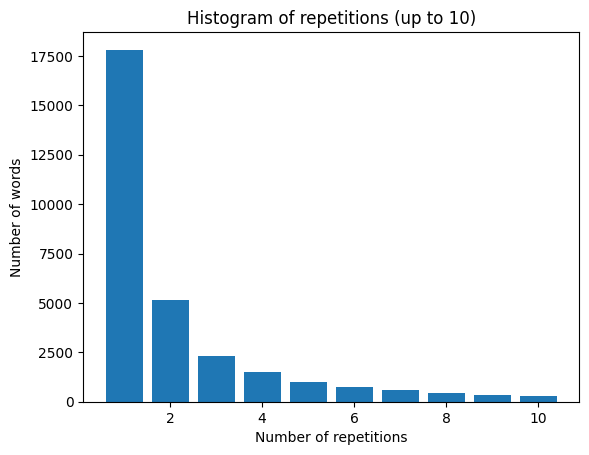

In [281]:
(x_values, y_values) = zip(*hist_quixote[:10])
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 10)')
plt.xlabel('Number of repetitions')
plt.ylabel('Number of words')
plt.show()

## Exercise 2. Histogram of the length of the words


Provide a histogram of the length of the words. Word repetition is not a problem, so if you have the word 'bye' twice in your document, you would add 2 to the number of words of length 3.

* Length 1 - 100 times
* Length 2 - 300 times
* Length 3 - 400 times
...

You are asked to implement a `histogram_length(file_path)` function in Spark. All the processing must be done with **DataFrames**, and there should be a single `collect()` at the end to return a list. The list must be ordered by the length of the words.

**Input**: A text document or multiple text documents

**Output**: (Length, number of words)

**Note: We are going to assume that the maximum word length is 16 characters, so anything above that shouldn't appear in the result.**

                                                                                                       [30 marks]

In [356]:
def histogram_length(file_path):
    # <FILL-IN WITH YOUR CODE>
    text=spark.read.text(file_path)
    
    text1=text.select(F.split(text["value"]," ").alias("words"))
    
    text2=text1.select(F.explode("words"))
    text3=text2.filter("col != ''")
    text3=text3.select(F.length(text2["col"]))
    text4=text3.groupBy(text3["length(col)"]).count()
    text5=text4.sort(text4["length(col)"].asc()).show()

histogram_length('data/quixote.txt')

+-----------+-----+
|length(col)|count|
+-----------+-----+
|          1|12978|
|          2|80003|
|          3|98414|
|          4|80717|
|          5|45809|
|          6|33672|
|          7|30995|
|          8|19570|
|          9|12350|
|         10| 7929|
|         11| 3849|
|         12| 2043|
|         13|  963|
|         14|  539|
|         15|  251|
|         16|  110|
|         17|   36|
|         18|   14|
|         19|   12|
|         20|    2|
+-----------+-----+
only showing top 20 rows



In [357]:
length_quixote = histogram_length("data/quixote.txt")
print(length_quixote)
test(length_quixote, [(1, 12978), (2, 80003), (3, 98414), (4, 80717), (5, 45809), 
                                   (6, 33672), (7, 30995), (8, 19570), (9, 12350), (10, 7929),
                                   (11, 3849), (12, 2043), (13, 963), (14, 539), (15, 251), (16, 110)],"Try again!")

+-----------+-----+
|length(col)|count|
+-----------+-----+
|          1|12978|
|          2|80003|
|          3|98414|
|          4|80717|
|          5|45809|
|          6|33672|
|          7|30995|
|          8|19570|
|          9|12350|
|         10| 7929|
|         11| 3849|
|         12| 2043|
|         13|  963|
|         14|  539|
|         15|  251|
|         16|  110|
|         17|   36|
|         18|   14|
|         19|   12|
|         20|    2|
+-----------+-----+
only showing top 20 rows

None
1 test failed. Try again!


## Exercise 3. Average length of the words in a document

You are now asked to implement an `average_length(file_path)` function in Spark that provides the average length of the words in a document or documents. All the processing must be done with  using **DataFrames**., and the last instruction must be the only one returning a result to the driver. 

**Input**: The path to a text file

**Output**: Average length of the words

**Note: Again, we are going to assume that the maximum word length is 16 characters, so anything above that shouldn't be used to compute the average**

**Hint**: You might be able to use some built-in functions from Spark!

                                                                                                       [30 marks]

In [395]:
def average_length(file_path):
    # <FILL-IN WITH YOUR CODE>
    text=spark.read.text(file_path)
    text=text.select(text['value'])
    text1=text.select(F.split(text['value']," ").alias("a"))
    text2=text1.select(F.explode("a"))
    text3=text2.filter(text2['col']!='')
    text4=text3.select(F.length(text3["col"]))
    text5=text4.agg(F.avg("length(col)"))
    
    return text5.collect()[0][0]
average_length("data/quixote.txt")

SyntaxError: invalid syntax (969267628.py, line 11)

The program should pass the following test:

In [394]:
avg = average_length("data/quixote.txt")
test(round(avg,2), 4.37,'Try again!')

1 test passed.
